How can the European bank identify and predict key factors driving customer churn, and what strategies can be implemented to reduce churn based on customer profiles and behavior patterns?

In [432]:
# IMPORTS 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from tabulate import tabulate

In [433]:
# LOADING THE DATA 
df = pd.read_csv('churn_bank.csv')

NRows, NColumns = df.shape
columnNames = list(df.columns)

# Creating two additional datasets for future comparison
dfStayed = df.loc[df['Exited']==1]
dfExited = df.loc[df['Exited']==0]

In [434]:
#####
# List of functions - used in our code to plot charts (several chart type are used multiple times, we therefore avoid duplicates of big paragraphs of code)
# We faced issues with VS CODE to import the functions from another file, which would have been ideal
#####

# DENSITY CHART 
def plot_density(data, x_col, hue_col=None, fill=True, title=None, xlabel=None, ylabel='Density'):
    """
    Generates a density plot for a given dataset.

    Parameters (those are the inputs you have to enter in your main code):
    - data: the dataset to plot
    - x_col: the column to plot the density for
    - hue_col: the column to group data by different categories (e.g., 'Geography')
    - fill: whether to fill the area under the curve (default: True)
    - title: the title of the plot
    - xlabel: the label for the x-axis
    - ylabel: str, optional, the label for the y-axis (default: 'Density')
    """

    sns.kdeplot(data=data, x=x_col, hue=hue_col, fill=fill)
    
    # Set plot title and labels
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(x_col)
    plt.ylabel(ylabel)
    

    plt.show()

#####
# STACKED BAR CHART - INTERACTION OF VARIABLES
def plot_stacked_bar(df, group_col, category_col, title):
    # Group and normalize values to get proportions in percentage
    df_grouped = (
        df.groupby(group_col)[category_col]
        .value_counts(normalize=True)
        .mul(100)
        .round(2)
        .unstack()
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    # Plot each category as a bar
    bottom = None
    for category in df_grouped.columns:
        ax.bar(
            df_grouped.index,
            df_grouped[category],
            label=category,
            width=0.3,
            bottom=bottom
        )
        # Update bottom for stacking
        bottom = df_grouped[category] if bottom is None else bottom + df_grouped[category]

    ax.set(
        title=title,
        xlabel="",
        ylabel="Proportion (%)",
    )
    ax.legend(title=category_col)
    plt.show()

#####
# REGULAR BAR CHART - ONE VARIABLE TO PLOT 
def plot_bar_single(df, category_col, title, colors):

    category_counts = df[category_col].value_counts(normalize=True)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        palette=sns.color_palette(colors)
    )

    sns.set_theme(style="darkgrid")
    ax.set(
        title=title,
        xlabel=category_col,
        ylabel="Proportion"
    )
    
    plt.show()


# Correlation Analysis 

### Calculating the differences in summary statistics

In [435]:
## calculating the differences in summary statistics
columnNamesDescribe = list(df.columns.drop(['Surname', 'Geography', 'Gender']))
columns2keep = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
columns2Drop = [val for val in columnNamesDescribe if val not in columns2keep]

differences_in_trends = np.array(dfExited.describe().T.drop(columns2Drop)) - np.array(dfStayed.describe().T.drop(columns2Drop))
#differences_in_trends = (np.array(dfExited.describe().T.drop(columns2Drop)) - np.array(dfStayed.describe().T.drop(columns2Drop)))/np.array(dfStayed.describe().T.drop(columns2Drop))
#len(columnNames)-len(differences_in_trends)
differences_in_trends = pd.DataFrame(differences_in_trends).set_index(pd.Index(columns2keep))

headers=['variable', 'count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
table = [pd.DataFrame(columns2keep), pd.DataFrame(differences_in_trends)]
print(tabulate(differences_in_trends, headers))

variable           count           mean           std    min        25%       50%       75%        max
---------------  -------  -------------  ------------  -----  ---------  --------  --------  ---------
CreditScore         5926       6.5017      -4.66767    55          7          7        2          0
Age                 5926      -7.42961      0.363801    0         -7         -9      -10          8
Tenure              5926       0.100535    -0.0554485   0          1          0       -1          0
Balance             5926  -18363.2       4487.25        0     -38340     -17276.6  -5023.05  -29365.3
EstimatedSalary     5926   -1727.29      -506.831      78.49   -1124.23   -2815.8  -3812.95     184.38


### Making dictionaries for the general descriptions

In [436]:
# creating a dictionary for all types
types_df = df.dtypes.to_frame(name="type")

types = {}
for i in range(0, 13):
    types[columnNames[i]] = types_df.iloc[i, 0].type

In [437]:
# creating a dictionary for all mins, means, maxs, ...
df_describe = df.describe().T

mins_df = df_describe.loc[:,"min"]
maxs_df = df_describe.loc[:,"max"]
means_df = df_describe.loc[:,"mean"]
median_df = df_describe.loc[:,"50%"]
std_df = df_describe.loc[:,"std"]

mins = {}
means = {}
maxs = {}
medians = {}
stds = {}

for i in range(len(df_describe)):
    key = columnNamesDescribe[i]
    mins[key] = mins_df.iloc[i]
    maxs[key] = maxs_df.iloc[i]
    means[key] = means_df.iloc[i]
    medians[key] = median_df.iloc[i]
    stds[key] = std_df.iloc[i]

### Correlation Matrix

[Text(0.5, 1.0, 'Overview: Correlation matrix')]

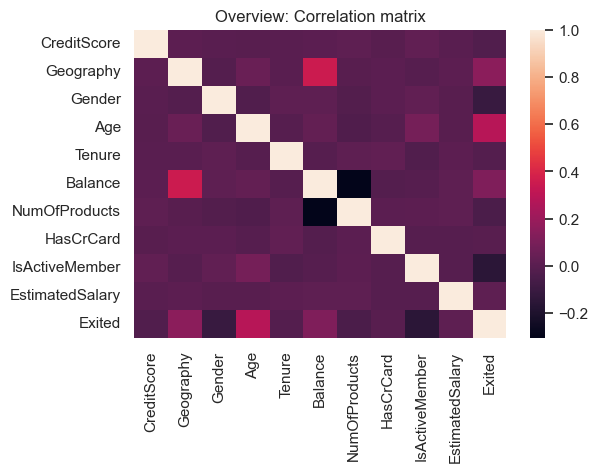

In [438]:
# The correlation matrix function only takes numerical values not string. 
# Therefore we transform the Geography and Gender as numerical values (dummies).
COUNTRY = {"France":"1",
        "Spain":"2",
        "Germany":"3"}
GENDER = {"Female":"1",
        "Male":"2"}

df_corr = df.copy()
df_corr.replace({'Geography': COUNTRY, 'Gender': GENDER}, inplace=True) 

df_corr = df_corr.drop(columns=["Surname", "CustomerId"])
# computing it
matrix_corr = df_corr.corr()
# plotting
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix_corr)
# title and axis labels
ax.set(
    title="Overview: Correlation matrix"
)

# # save figs for LATEX 
# plt.tight_layout() 
# plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/CorrelationMatrix_1.png')

# General Analysis

### INDIVIDUAL DISTRIBUTION OF VARIABLES 

### Customer profile: Gender, Age and Geography

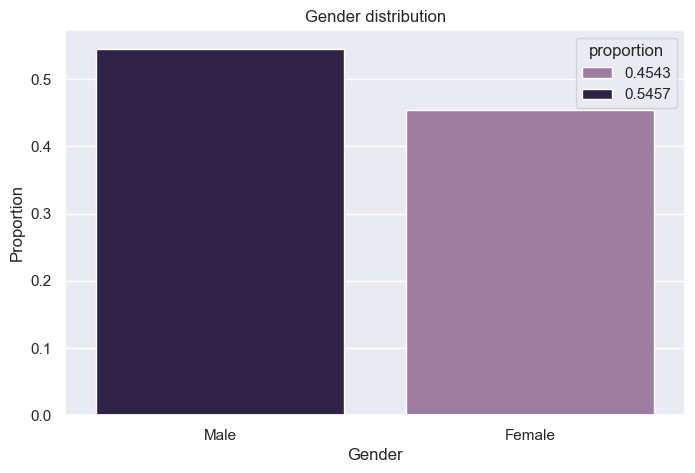

The bank has 4543 female clients (45.43% of the total) and 5457 male clients (54.57%).


/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/819509529.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


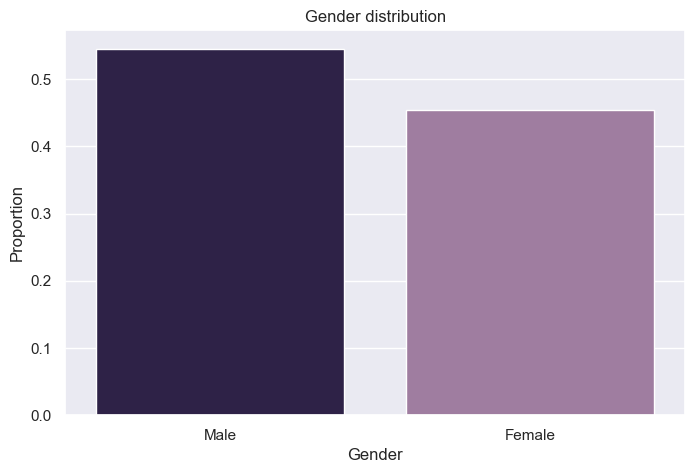

In [548]:
# GENDER 
# Gender is a binary categorical variable that can take 2 values: Male or Female. 

fig, ax = plt.subplots(figsize = (8,5))

gender_palette = ["#a577a6", "#2c1c4d"]

sns.barplot(x = df["Gender"].value_counts().index,
            y = df["Gender"].value_counts(normalize=True), 
            hue=df["Gender"].value_counts(normalize=True),
            palette=sns.color_palette(gender_palette)
)
sns.set_theme(style="darkgrid")
ax.set(
    title = "Gender distribution",
    xlabel = "Gender",
    ylabel = "Proportion"
)
plt.show()

message = "The bank has {} female clients ({}% of the total) and {} male clients ({}%).".format(
    df["Gender"].value_counts().iloc[1],
    df["Gender"].value_counts(normalize=True).mul(100).round(2).iloc[1],
    df["Gender"].value_counts().iloc[0],
    df["Gender"].value_counts(normalize=True).mul(100).round(2).iloc[0]
)
print(message)



# plot_bar_single(
#     df=df,
#     category_col="Gender",
#     title="Gender distribution",
#     colors=["#2c1c4d", "#a577a6"]
# )



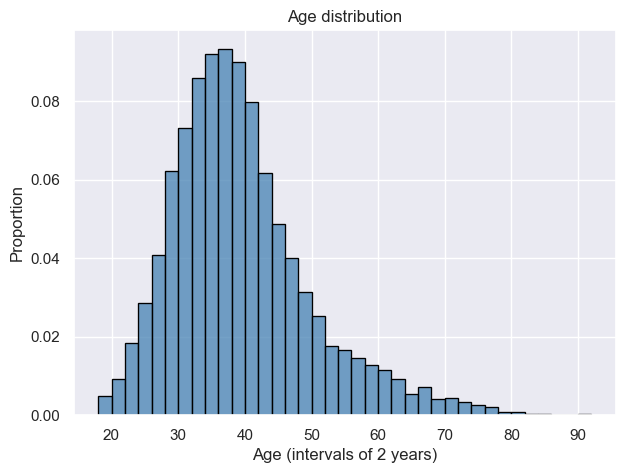

The bank's clients are between 18 and 92 years old, with the median age being 37.0 and a standard deviation of 10.49 years.


In [549]:
# AGE 

fig, ax = plt.subplots(figsize=[7, 5])

sns.histplot(
    x = df["Age"],
    stat='probability',
    binwidth = 2,
    color="steelblue",
    edgecolor = "black",
)

ax.set(
    title = "Age distribution",
    xlabel = "Age (intervals of 2 years)",
    ylabel = "Proportion"
)
sns.set_theme(style="darkgrid")
plt.show()

message = "The bank's clients are between {} and {} years old, with the median age being {} and a standard deviation of {} years.".format(
    int(mins["Age"]), int(maxs["Age"]),
    round(medians["Age"], 2), round(stds["Age"], 2)
)
print(message)

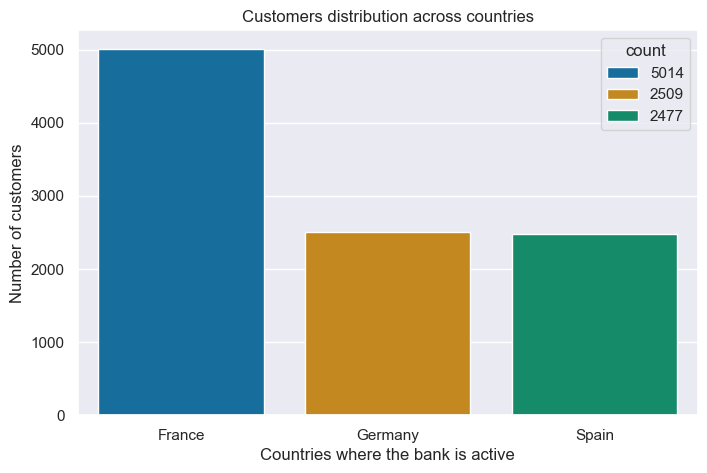

The bank's clients are majoritarily from France (50.14 percent),
followed closely by Germany and Spain (25.09 and 24.77 percent of the total respectively).


/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/819509529.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/819509529.py:75: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(


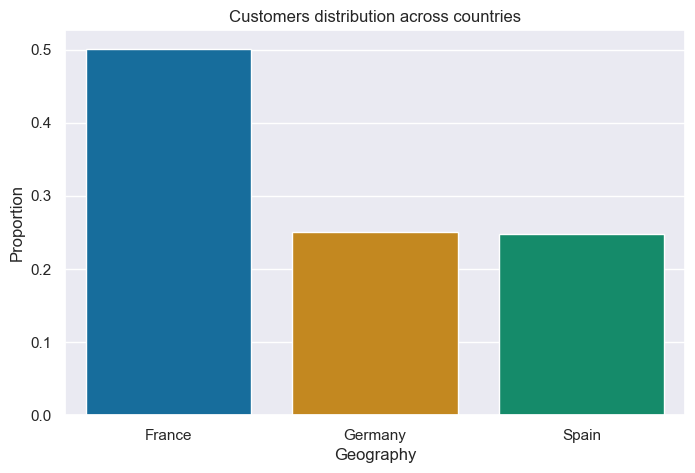

In [654]:
# GEOGRAPHY 

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = df["Geography"].value_counts().index,
            y = df["Geography"].value_counts(),
            hue=df["Geography"].value_counts(),
            hue_order = df["Geography"].value_counts(),
            palette=sns.color_palette("colorblind", 3)
            )

sns.set_theme(style="darkgrid")

ax.set(
    title = "Customers distribution across countries",
    xlabel = "Countries where the bank is active",
    ylabel = "Number of customers"
)
plt.show()

message = "The bank's clients are majoritarily from France ({} percent),\nfollowed closely by Germany and Spain ({} and {} percent of the total respectively).".format(
    df["Geography"].value_counts(normalize=True).mul(100).round(2).iloc[0],
    df["Geography"].value_counts(normalize=True).mul(100).round(2).iloc[1],
    df["Geography"].value_counts(normalize=True).mul(100).round(2).iloc[2]
)
print(message)



# plot_bar_single(
#     df=df,
#     category_col="Geography",
#     title="Customers distribution across countries",
#     colors="colorblind"
# )


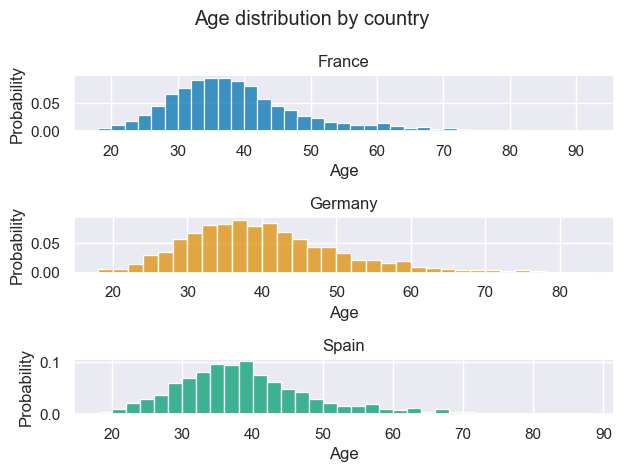

In [655]:
# AGE AND GEOGRAPHY

fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(country)

    this_df = df[df["Geography"] == country]

    sns.histplot(
        x = this_df["Age"],
        stat='probability',
        color=sns.color_palette("colorblind")[i],
        binwidth = 2,
        ax=ax[i]
    )

sns.set_theme(style="darkgrid")
fig.suptitle('Age distribution by country')
fig.tight_layout()
plt.show()

### Customer Description: Financial Analysis

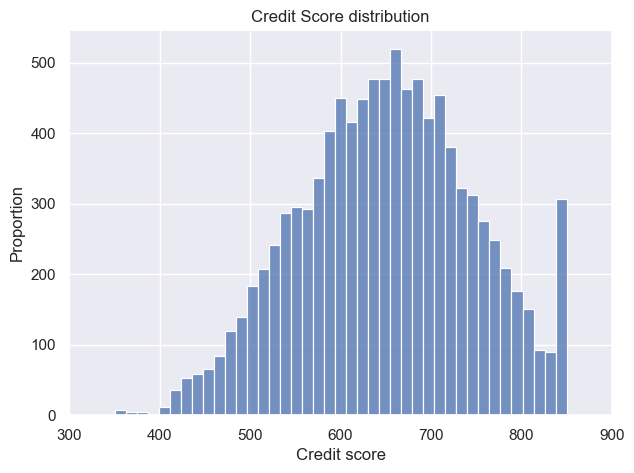

The average credit score is around 650.5288, with a standard deviation of 96.65 points.
We observe an interesting peak in the proportion of people who have a credit score around 850.


In [656]:
# CREDIT SCORE 
# Credit score is a number from 300 to 850 that rates a consumer's creditworthiness. 
# It represents a customer's credit history and your ability to pay your loans and financial obligations. 
# In particular, the FICO score divides credit score into different intervals to simplify the interpretation of the score according to each customer. 

fig, ax = plt.subplots(figsize=[7, 5])

sns.histplot(
    x = df["CreditScore"]
)
plt.xlim([300, 900]) 

ax.set(
    title = "Credit Score distribution",
    xlabel = "Credit score",
    ylabel = "Proportion"
)
plt.show()

message = "The average credit score is around {}, with a standard deviation of {} points.\nWe observe an interesting peak in the proportion of people who have a credit score around 850.".format(
    means["CreditScore"],
    round(stds["CreditScore"], 2)
)
print(message)

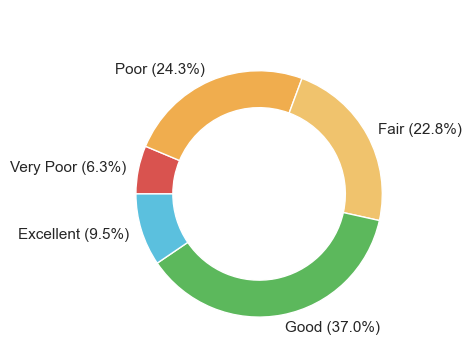

In [657]:
# CATEGORICAL CREDIT SCORE

df["CreditScore"].unique()
df["CreditScore"].min()
df["CreditScore"].max()
# in our data [350 - 850]

# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df['Credit_Category'] = df['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles 
proportions = category_counts.values
angles = proportions * 180  

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()


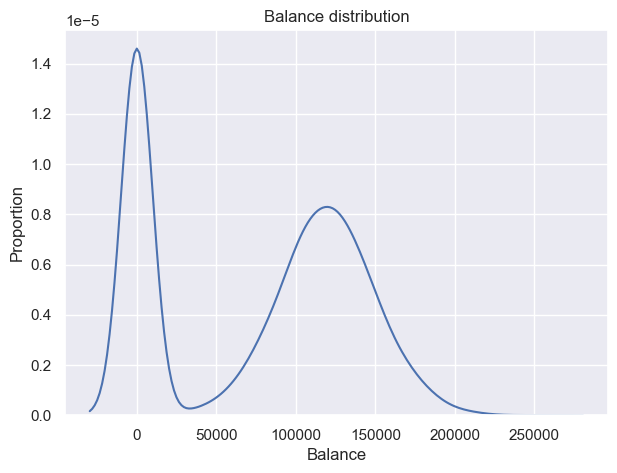

The average balance is of 76485.89€ and the median is of 97198.54€.
This is because the proportion of people whose balance is at 0 is considerable: 36.17 percent.


In [658]:
# BALANCE 

fig, ax = plt.subplots(figsize=[7, 5])

sns.kdeplot(
    x = df["Balance"],#.value_counts()), 
    #y = df_exited["Age"].value_counts(normalize=True),
)
ax.set(
    title = "Balance distribution",
    xlabel = "Balance",
    ylabel = "Proportion"
)
plt.show()


message = "The average balance is of {}€ and the median is of {}€.\nThis is because the proportion of people whose balance is at 0 is considerable: {} percent.".format(
    round(means["Balance"],2),
    round(medians["Balance"],2),
    round((len(df.query("Balance == 0"))/NRows)*100,2)
)
print(message)


In [659]:
print(f"The percentage of people in the bank with a 0 balance is {100*len(df[df['Balance'] == 0])/NRows}.")

The percentage of people in the bank with a 0 balance is 36.17.


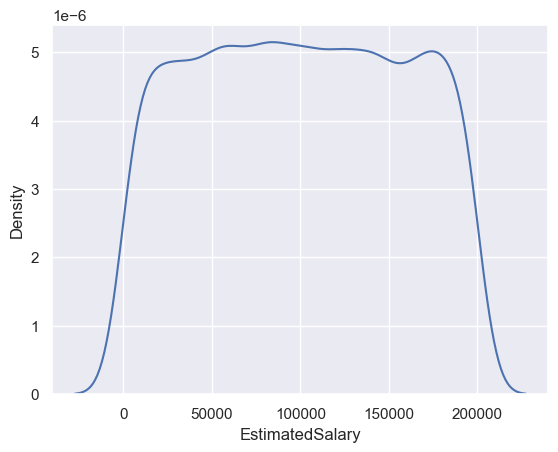

The average estimated salary is of 100090.24€ and the median is of 100193.92€.
It is interesting to note that we observe a very uniform distribution across all values, with a slight peak at the end of the distribution.


In [660]:
# ESTIMATED SALARY

sns.kdeplot(
    x = df["EstimatedSalary"],#.value_counts()), 
    #y = df_exited["Age"].value_counts(normalize=True)
)
ax.set(
    title = "Estimated salary distribution",
    xlabel = "Estimated salary",
    ylabel = "Proportion"
)
plt.show()

message = "The average estimated salary is of {}€ and the median is of {}€.\nIt is interesting to note that we observe a very uniform distribution across all values, with a slight peak at the end of the distribution.".format(
    round(means["EstimatedSalary"],2),
    round(medians["EstimatedSalary"],2)
)

print(message)

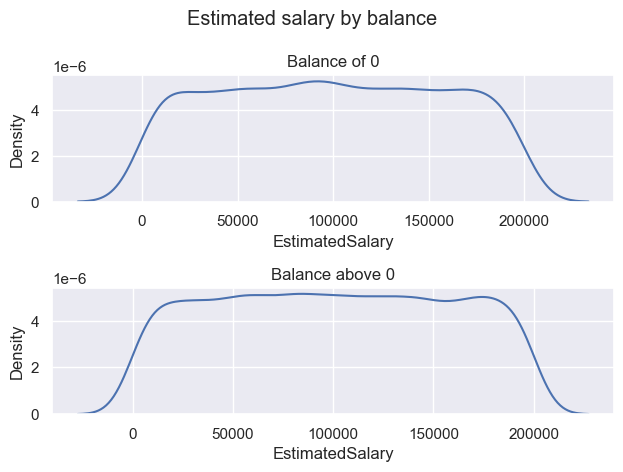

In [661]:
# ESTIMATED SALARY AND BALANCE 

balance_differences = [df[df['Balance'] == 0], df[df['Balance'] != 50000]]
balance_types = ["Balance of 0", "Balance above 0"]

fig, ax = plt.subplots(2, 1)
for i in range(2):
     
    dataframe = balance_differences[i]

    ax[i].set_title(balance_types[i])
    sns.kdeplot(
    x = dataframe["EstimatedSalary"],ax=ax[i]
)

sns.set_theme(style="darkgrid")
fig.suptitle('Estimated salary by balance')
fig.tight_layout()
plt.show()

### Customer Description: Activity

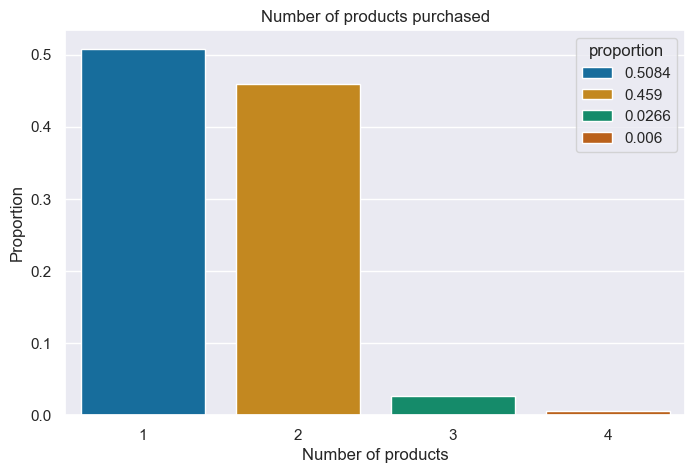

Observing the number of products the customer contracted with the bank, we can see customers have bought at least 1 product.
This product might need to be necessary to be classified as a bank cutsomer because no customer has bought no products.
This product could tus be a bank account. 
Almost half have bought 2, and under 5 percent have bought more.
However, we have to be careful when comparing all groups amongst eachother,
since the sizes of people having purchased 3 and 4 products are too small: 
266 and 60 compared to 5084 and 4590 for 1 and 2 prodcts purchased respectively.


In [662]:
# NUMBER OF BANK PRODUCTS PURCHASED BY THE CUSTOMER 

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = df["NumOfProducts"].value_counts().index,
            y = df["NumOfProducts"].value_counts(normalize=True),
            hue = df["NumOfProducts"].value_counts(normalize=True),
            hue_order = df["NumOfProducts"].value_counts(normalize=True),
            palette = sns.color_palette("colorblind", 4)
            )

ax.set(
    title = "Number of products purchased",
    xlabel = "Number of products",
    ylabel = "Proportion"
)

plt.show()
message = "Observing the number of products the customer contracted with the bank, we can see customers have bought at least 1 product.\nThis product might need to be necessary to be classified as a bank cutsomer because no customer has bought no products.\nThis product could tus be a bank account. \nAlmost half have bought 2, and under 5 percent have bought more.\nHowever, we have to be careful when comparing all groups amongst eachother,\nsince the sizes of people having purchased 3 and 4 products are too small: \n{} and {} compared to {} and {} for 1 and 2 prodcts purchased respectively.".format(
    len(df.query("NumOfProducts == 3")),
    len(df.query("NumOfProducts == 4")),
    len(df.query("NumOfProducts == 1")),
    len(df.query("NumOfProducts == 2"))
)
print(message)

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/2835436514.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(("No", "Yes"))


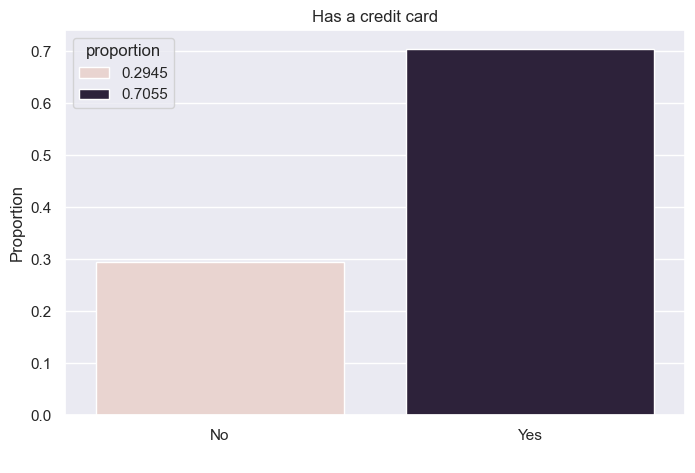

In [663]:
# HAVING A CREDIT CARD 

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(
            x = df["HasCrCard"].value_counts().index,
            y = df["HasCrCard"].value_counts(normalize=True),
            hue=df["HasCrCard"].value_counts(normalize=True),
            )
ax.set_xticklabels(("No", "Yes"))
ax.set(
    title = "Has a credit card",
    xlabel = " ",
    ylabel = "Proportion"
)
plt.show()

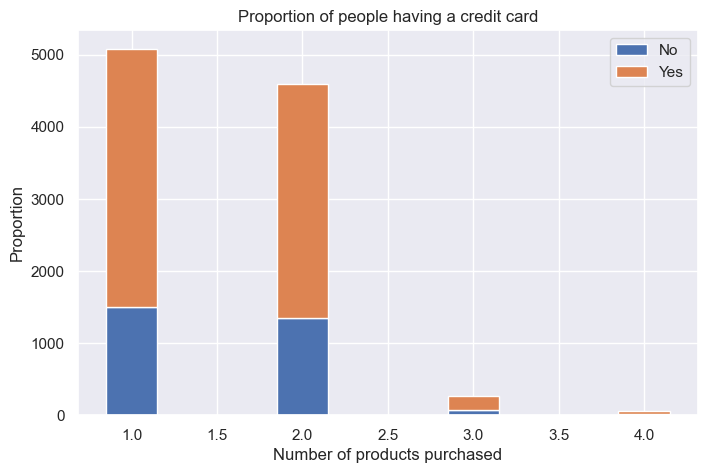

However, we also observe that not all people who have purchased two products have a credit card, so a credit card cannot be the second product.


In [664]:
# HYPOTHESIS TEST : IS "product 2" a credit card, and "product 1" the bank account itself? 

df_prod_crcard = (df
      .groupby("NumOfProducts")["HasCrCard"]
      .value_counts()
      #.mul()
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_prod_crcard.index, df_prod_crcard[0], label = 'No', width = 0.3) 
ax.bar(df_prod_crcard.index, df_prod_crcard[1], bottom = df_prod_crcard[0], label='Yes', width = 0.3)

ax.set(
    title = "Proportion of people having a credit card",
    xlabel = "Number of products purchased",
    ylabel = "Proportion"
)
ax.legend()
plt.show()

message = "However, we also observe that not all people who have purchased two products have a credit card, so a credit card cannot be the second product."
print(message)

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/2372004430.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Not recently active", "Recently active"])


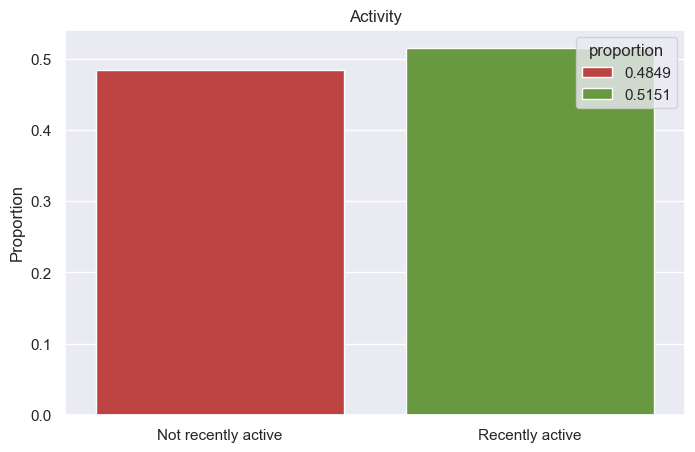

In [665]:
# BEING AN ACTIVE MEMBER 

fig, ax = plt.subplots(figsize = (8,5))
colors = ["#d12f2c","#66a832"]
sns.barplot(
            x = df["IsActiveMember"].value_counts().index,
            y = df["IsActiveMember"].value_counts(normalize=True),
            hue=df["IsActiveMember"].value_counts(normalize=True), 
            palette = sns.color_palette(colors)
            )
ax.set_xticklabels(["Not recently active", "Recently active"])

sns.set_theme(style="darkgrid")
ax.set(
    title = "Activity",
    xlabel = "",
    ylabel = "Proportion"
)
plt.show()

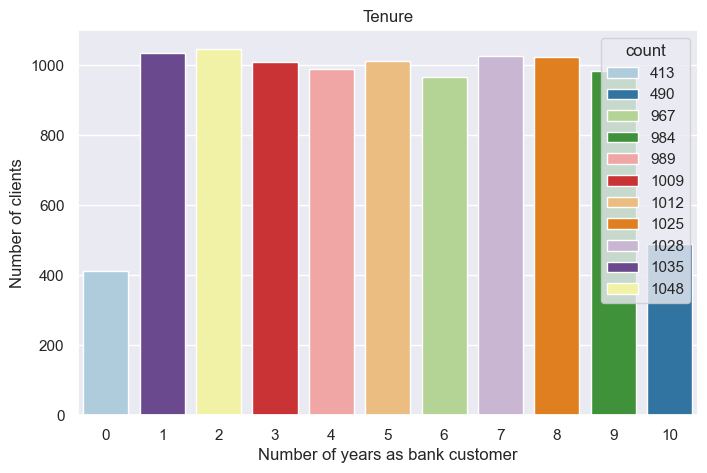

There is a uniform repartition of the amount of years the customers have been with this bank,
expect for those that have been with it for 10 years or are newcomers.
The bank is possibly 10 years old?


In [666]:
# TENURE 
# Tenure is the number of years the customer has been a client of the bank.

fig, ax = plt.subplots(figsize=[8, 5])

sns.barplot(
    x = df["Tenure"].value_counts().index, 
    y = df["Tenure"].value_counts(),
    hue = df["Tenure"].value_counts(),
    #hue_order = df["Tenure"].index,
    palette = sns.color_palette("Paired",11)
)
ax.set(
    title = "Tenure",
    xlabel = "Number of years as bank customer",
    ylabel = "Number of clients"
)

plt.show()

message = "There is a uniform repartition of the amount of years the customers have been with this bank,\nexpect for those that have been with it for 10 years or are newcomers.\nThe bank is possibly 10 years old?"
print(message)

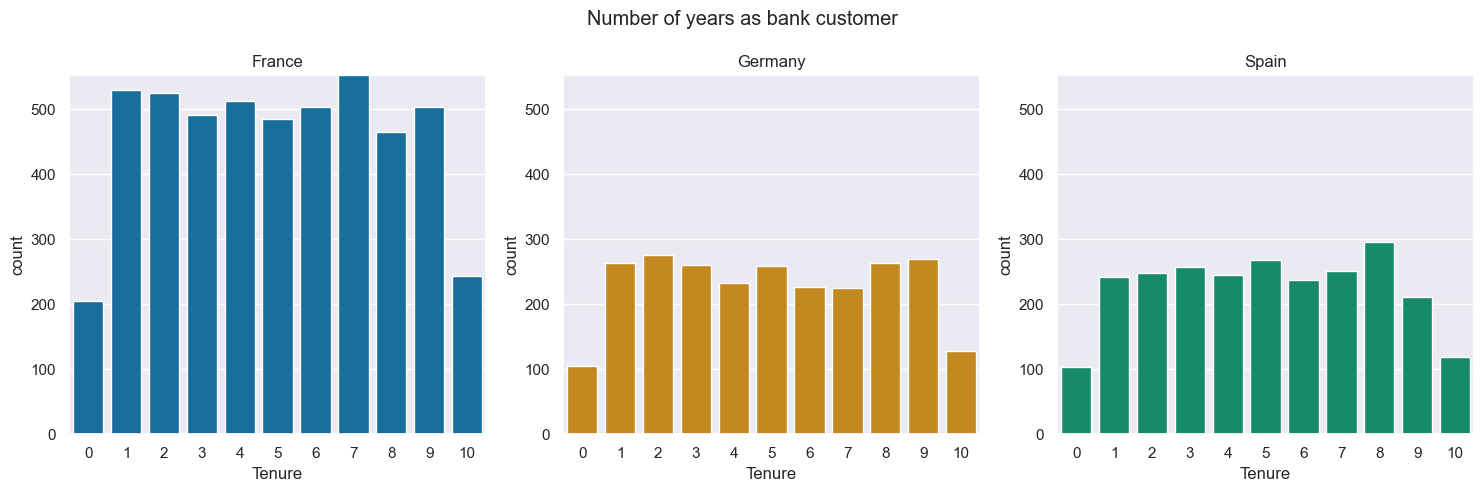

In [667]:
# TENURE AND GEOGRAPHY

country_differences = [df[df['Geography'] == "France"], df[df['Geography'] == "Germany"], df[df['Geography'] == "Spain"]]
country_types = ["France", "Germany", "Spain"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
max_count = max([dataframe["Tenure"].value_counts().max() for dataframe in country_differences])

for i in range(3):
    dataframe = country_differences[i]
    ax[i].set_title(country_types[i])
    ax[i].set_ylim(0, max_count)

    sns.barplot(
        x = dataframe["Tenure"].value_counts().index, 
        y = dataframe["Tenure"].value_counts(), 
        ax = ax[i], 
        color=colors[i]
        )
    fig.suptitle('Number of years as bank customer')

fig.tight_layout()
plt.show()


### HOW DO DIFFERENT VARIABLES INTERACT WITH EACH OTHER?

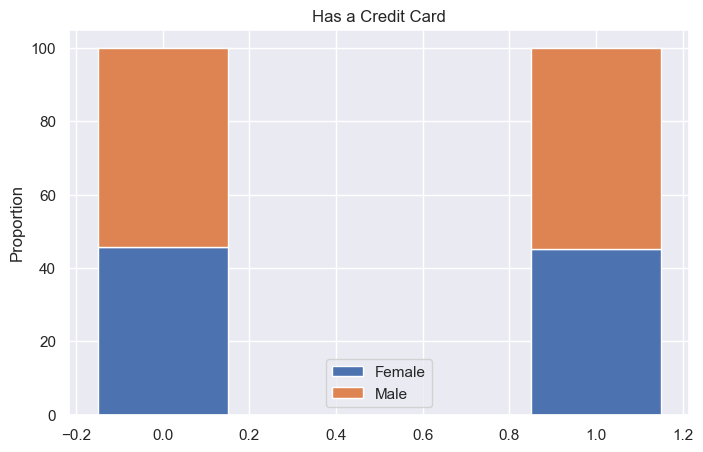

Gender differences don't explain having or not having a credit card.


In [668]:
# Interaction between Gender and Owning a credit card

df_card_gender = (df
      .groupby("HasCrCard")["Gender"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_card_gender.index, df_card_gender["Female"], label = 'Female', width = 0.3) 
ax.bar(df_card_gender.index, df_card_gender["Male"], bottom = df_card_gender["Female"],  label='Male', width = 0.3)

ax.set(
    title = "Has a Credit Card",
    xlabel = "",
    ylabel = "Proportion",
)
ax.legend()
plt.show()

message = "Gender differences don't explain having or not having a credit card."
print(message)

# plot_stacked_bar(df, "HasCrCard", "Gender", "Proportion of credit card owners per sex")

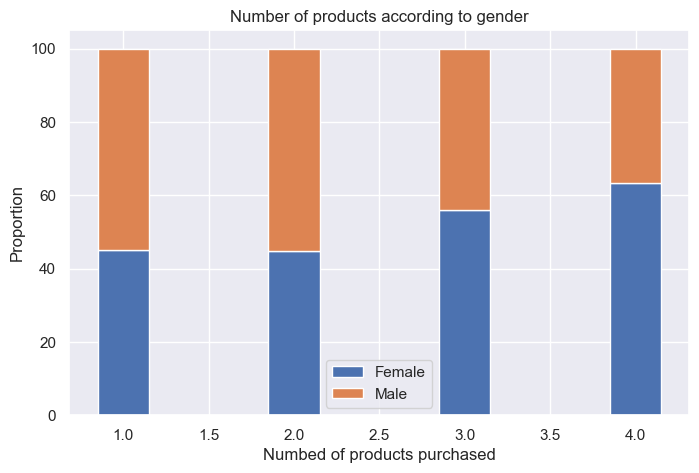

We can see women appear more likely than men to buy more than two products.
However, again, we have to be careful when comparing because there are very few people buying products 3 and 4.


In [669]:
# Interaction between Gender and the number of products bought 

df_prods_gender = (df
      .groupby("NumOfProducts")["Gender"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack(fill_value=0))

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_prods_gender.index, df_prods_gender["Female"], label = 'Female', width = 0.3) 
ax.bar(df_prods_gender.index, df_prods_gender["Male"], bottom = df_prods_gender["Female"], label='Male', width = 0.3)

ax.set(
    title = "Number of products according to gender",
    xlabel = "Numbed of products purchased",
    ylabel = "Proportion"
)
ax.legend()
plt.show()
message = "We can see women appear more likely than men to buy more than two products.\nHowever, again, we have to be careful when comparing because there are very few people buying products 3 and 4."
print(message)


# plot_stacked_bar(df, "NumOfProducts", "Gender", "Nbr of Products owned by gender")

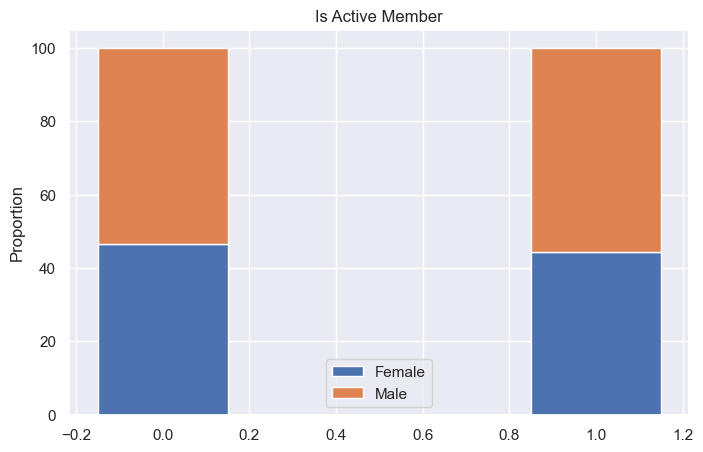

There are no significant gender differences in activity.


In [670]:
# Interaction between Gender and activity 

df_active_gender = (df
      .groupby("IsActiveMember")["Gender"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_active_gender.index, df_active_gender["Female"], label = 'Female',  width = 0.3) 
ax.bar(df_active_gender.index, df_active_gender["Male"], bottom = df_active_gender["Female"],  label='Male', width = 0.3)

ax.set(
    title = "Is Active Member",
    xlabel = "",
    ylabel = "Proportion",
)
ax.legend()
plt.show()

message = "There are no significant gender differences in activity."
print(message)

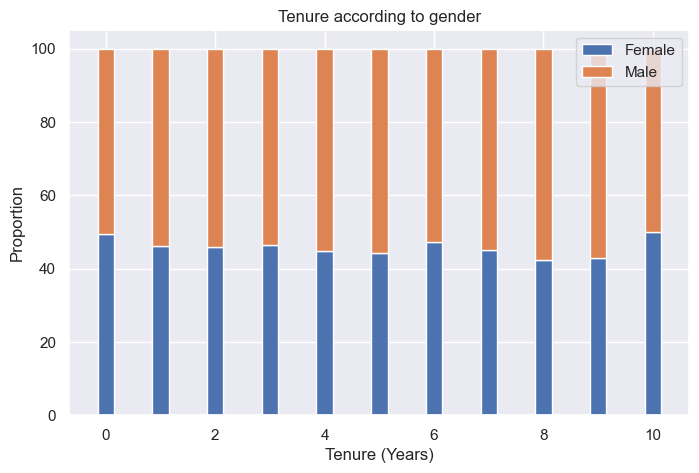

There doesn't seem to be any relation between tenure and gender.


In [671]:
# Interaction between Gender and the time spent in the bank 

df_tenure_gender = (df
      .groupby("Tenure")["Gender"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_tenure_gender.index, df_tenure_gender["Female"], label ="Female", width = 0.3) 
ax.bar(df_tenure_gender.index, df_tenure_gender["Male"], bottom = df_tenure_gender["Female"], label="Male", width = 0.3)

ax.set(
    title = "Tenure according to gender",
    xlabel = "Tenure (Years)",
    ylabel = "Proportion"
)
ax.legend()
plt.show()

message = "There doesn't seem to be any relation between tenure and gender."
print(message)

### Gender patterns in financial variables 

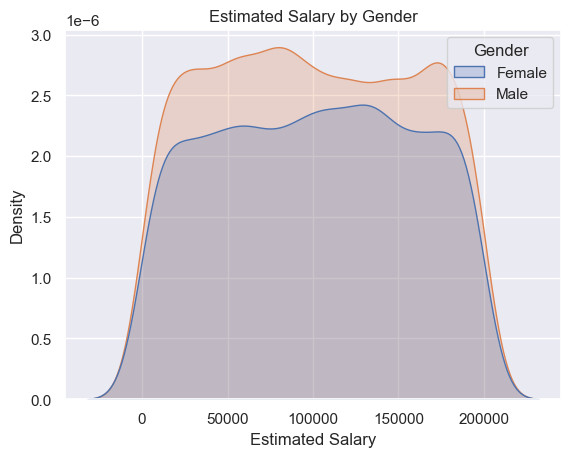

In [672]:
# Interaction between Gender and Estimated Salary 

sns.kdeplot(data=df, x="EstimatedSalary", hue="Gender", fill=True) 
plt.title('Estimated Salary by Gender') 
plt.xlabel('Estimated Salary') 
plt.ylabel('Density') 
plt.show() 

# plot_density(df, "EstimatedSalary", hue_col="Gender")

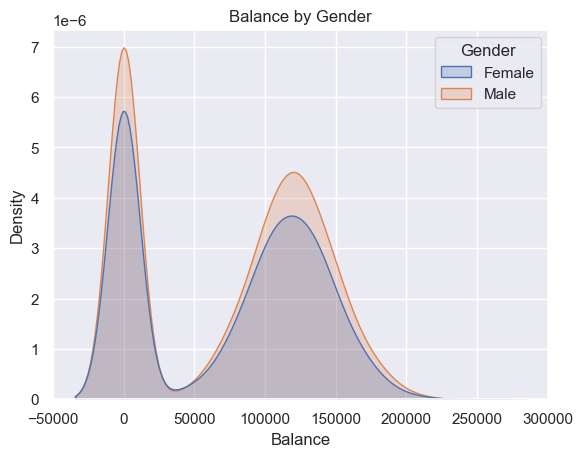

In [673]:
# Interaction between Gender and Balance level
sns.kdeplot(data=df, x="Balance", hue="Gender", fill=True) 
plt.title('Balance by Gender') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

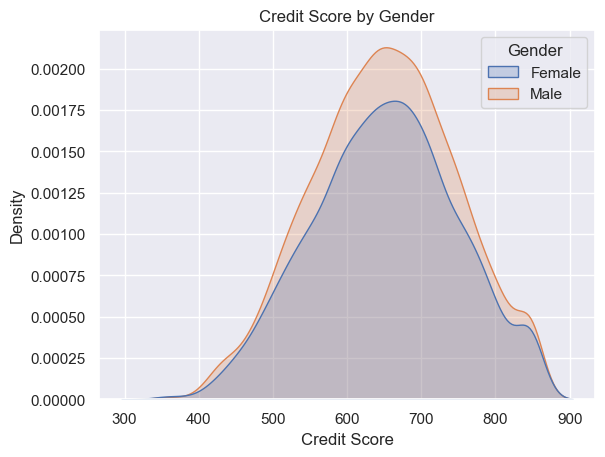

In [674]:
# Interaction between Gender and Credit Score 
sns.kdeplot(data=df, x="CreditScore", hue="Gender", fill=True) 
plt.title('Credit Score by Gender') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show() 

### Identifying possible activity patterns with financial data

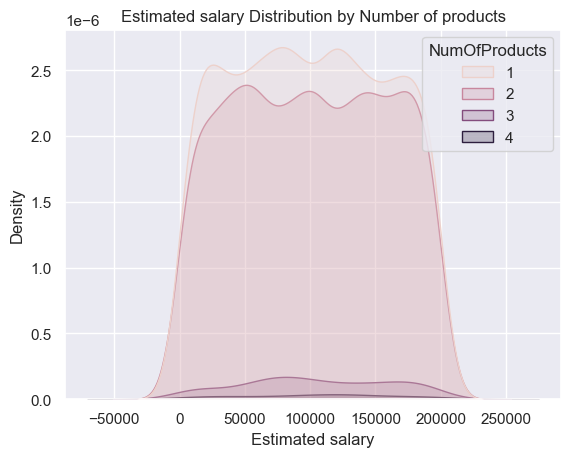

No trend sticks out.  
Again, we could question whether it is even interesting to look at number of products due to the small samples for products 3 and 4.


In [675]:
# Can the estimated salary tell us something about the number of product bought ? 

sns.kdeplot(data=df, x="EstimatedSalary", hue="NumOfProducts", fill=True) 
plt.title('Estimated salary Distribution by Number of products') 
plt.xlabel('Estimated salary') 
plt.ylabel('Density') 
plt.show() 

message = "No trend sticks out.  \nAgain, we could question whether it is even interesting to look at number of products due to the small samples for products 3 and 4."
print(message)

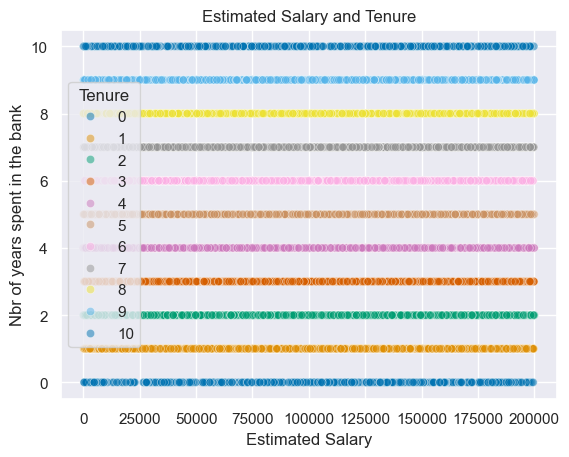

<Figure size 640x480 with 0 Axes>

In [676]:
    # Estimated salary and number of years spent in the bank 

sns.scatterplot(df, 
             x='EstimatedSalary', 
             y='Tenure', 
             hue = 'Tenure',
             palette= sns.color_palette("colorblind", 11),
             alpha=0.5) 
plt.xlabel('Estimated Salary') 
plt.ylabel('Nbr of years spent in the bank') 
plt.title('Estimated Salary and Tenure') 
plt.show()
plt.tight_layout() 

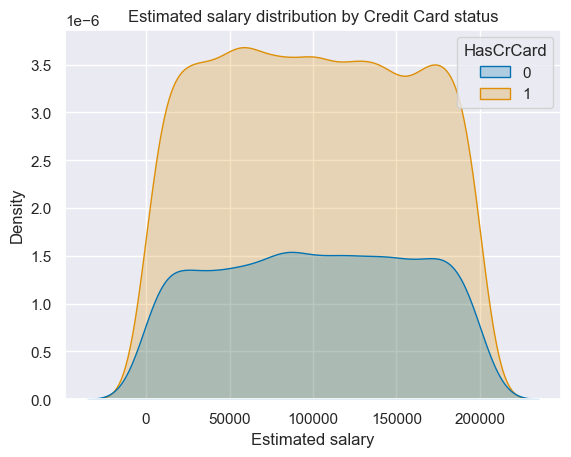

No trends stick out.


In [677]:
    # Estimated salary and Credit card

sns.kdeplot(data=df, x="EstimatedSalary", hue="HasCrCard", label=["Has a credit card"],
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Estimated salary distribution by Credit Card status') 
plt.xlabel('Estimated salary') 
plt.ylabel('Density') 
plt.show() 

message = "No trends stick out."
print(message)

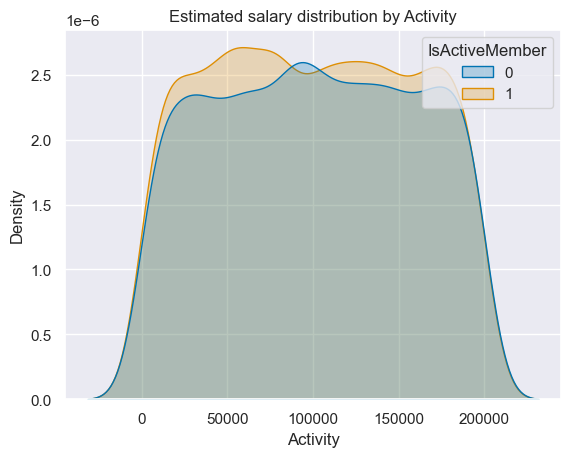

No trends stick out. 
We would have imagined a relationship with estimated salary but it doesnt seem to be a predictor of individual activity


In [678]:
    # Estimated salary and Activity

sns.kdeplot(data=df, x="EstimatedSalary", hue="IsActiveMember", label=["No","Yes"],
            # I dont know how to change label
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Estimated salary distribution by Activity') 
plt.xlabel('Activity') 
plt.ylabel('Density') 
plt.show() 

message = "No trends stick out. \nWe would have imagined a relationship with estimated salary but it doesnt seem to be a predictor of individual activity"
print(message)

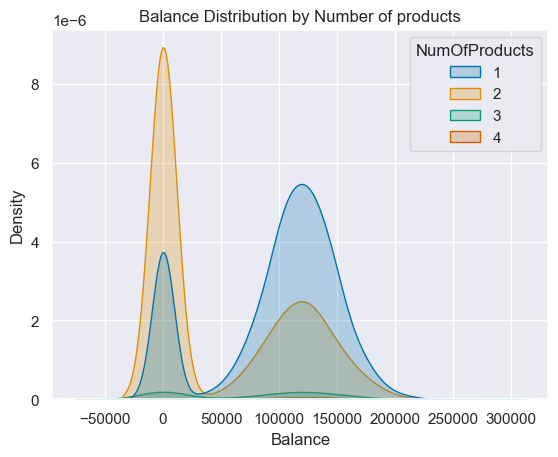

In [679]:
# Can the balance tell us something about the number of products bought ? 

sns.kdeplot(data=df, x="Balance", hue="NumOfProducts",
            palette=sns.color_palette("colorblind", 4), fill=True) 
plt.title('Balance Distribution by Number of products') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

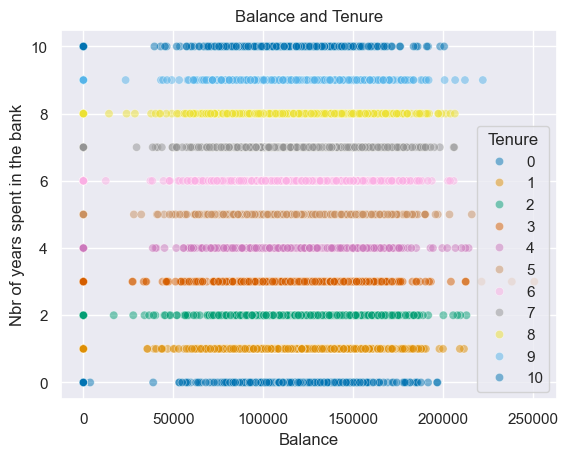

<Figure size 640x480 with 0 Axes>

In [680]:
    # Balance and Tenure 
sns.scatterplot(df, 
             x='Balance', 
             y='Tenure', 
             hue = 'Tenure',
             palette= sns.color_palette("colorblind", 11),
             alpha=0.5) 
plt.xlabel('Balance') 
plt.ylabel('Nbr of years spent in the bank') 
plt.title('Balance and Tenure') 
plt.show()
plt.tight_layout() 

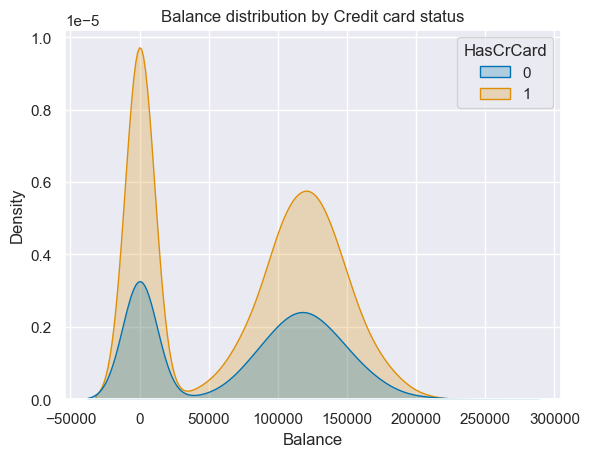

In [681]:
    # Balance and Credit Card owners 

sns.kdeplot(data=df, x="Balance", hue="HasCrCard", label=["No","Yes"],
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Balance distribution by Credit card status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

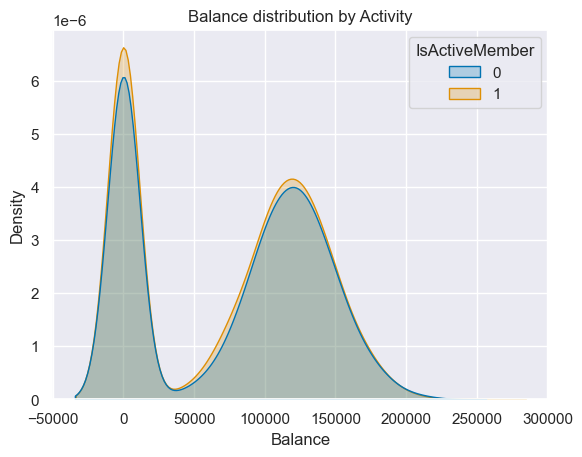

In [682]:
    # Balance and Activity

sns.kdeplot(data=df, x="Balance", hue="IsActiveMember", label=["No","Yes"],
            # I dont know how to change label
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Balance distribution by Activity') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

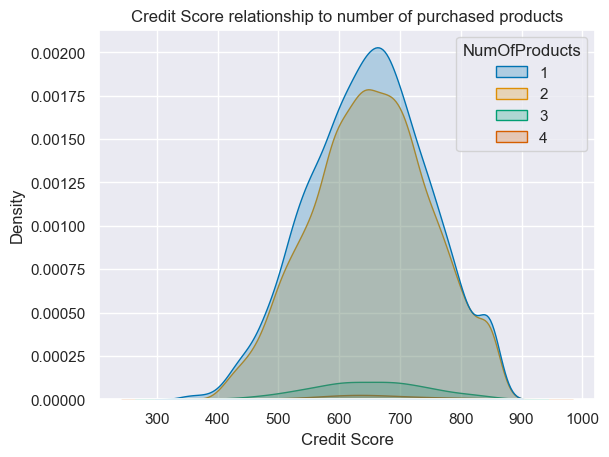

In [683]:
# Can the credit score tell us something about the activity of the customer ? 

    # Credit score and Number of products
sns.kdeplot(data=df, x="CreditScore", hue="NumOfProducts",
            palette=sns.color_palette("colorblind", 4), fill=True) 
plt.title('Credit Score relationship to number of purchased products') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show() 

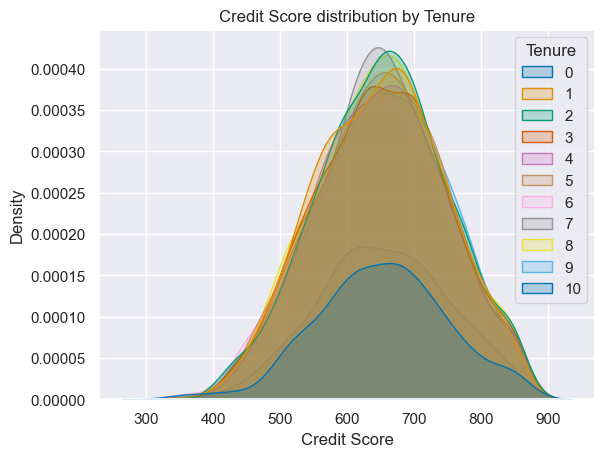

In [684]:
    # Credit Score and Tenure
sns.kdeplot(data=df, x="CreditScore", hue="Tenure", 
            palette=sns.color_palette("colorblind", 11), fill=True) 
plt.title('Credit Score distribution by Tenure') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show() 

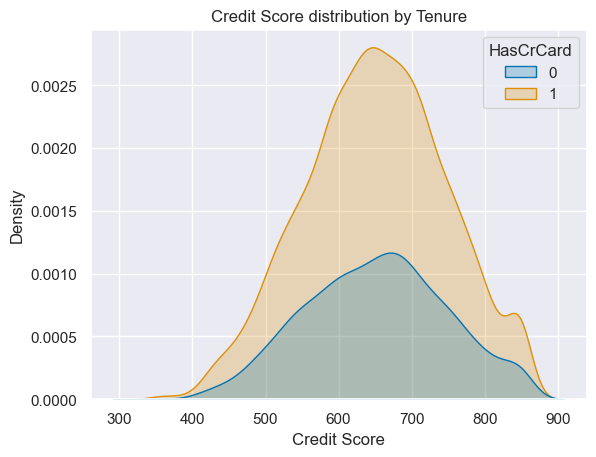

In [685]:
    # Credit Score and Credit card

sns.kdeplot(data=df, x="CreditScore", hue="HasCrCard", label=["No","Yes"],
            # I dont know how to change label
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Credit Score distribution by Tenure') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show()  

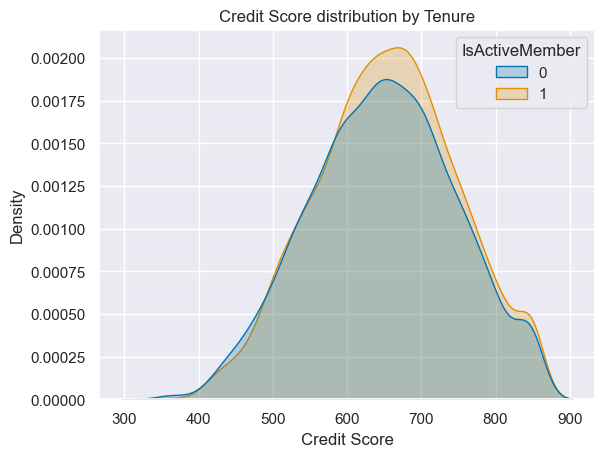

In [686]:
    # Credit Score and Activity

sns.kdeplot(data=df, x="CreditScore", hue="IsActiveMember", label=["No","Yes"],
            # I dont know how to change label
            palette=sns.color_palette("colorblind", 2), fill=True) 
plt.title('Credit Score distribution by Tenure') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show() 

### Geographic trends: How is Germany an exception? 

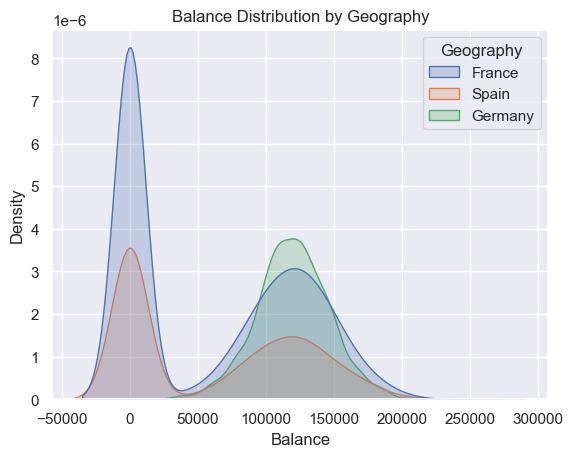

Germany doesn't seem to have low balances!


In [687]:
# How does Balance interact with Geography 

sns.kdeplot(data=df, x="Balance", hue="Geography", fill=True) 
plt.title('Balance Distribution by Geography') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

message ="Germany doesn't seem to have low balances!"
print(message)

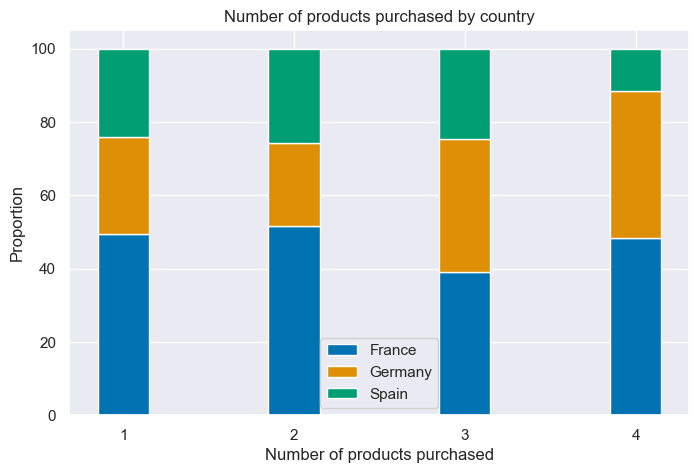

In [688]:
# Number of products, Geography
df_products_geography = (df
      .groupby("NumOfProducts")["Geography"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack(fill_value=0))

colorblind_colors = sns.color_palette("colorblind")
fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_products_geography.index, df_products_geography["France"], label = 'France', tick_label = ["1","2","3","4"], width = 0.3, color=colorblind_colors[0]) 
ax.bar(df_products_geography.index, df_products_geography["Germany"], bottom = df_products_geography["France"], label='Germany', width = 0.3, color=colorblind_colors[1])
ax.bar(df_products_geography.index, df_products_geography["Spain"], bottom = (df_products_geography["Germany"]+df_products_geography["France"]), label='Spain', width = 0.3, color=colorblind_colors[2])

ax.set(
    title = "Number of products purchased by country",
    xlabel = "Number of products purchased",
    ylabel = "Proportion"
)
ax.legend()
plt.show()

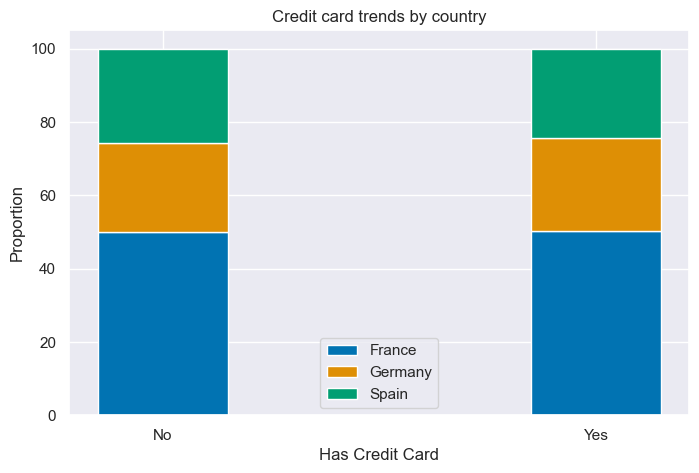

In [689]:
# Has credit card, Geography
df_products_geography = (df
      .groupby("HasCrCard")["Geography"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack(fill_value=0))

colorblind_colors = sns.color_palette("colorblind")
fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_products_geography.index, df_products_geography["France"], label = 'France', tick_label = ["No", "Yes"], width = 0.3, color=colorblind_colors[0]) 
ax.bar(df_products_geography.index, df_products_geography["Germany"], bottom = df_products_geography["France"], label='Germany', width = 0.3, color=colorblind_colors[1])
ax.bar(df_products_geography.index, df_products_geography["Spain"], bottom = (df_products_geography["Germany"]+df_products_geography["France"]), label='Spain', width = 0.3, color=colorblind_colors[2])


ax.set(
    title = "Credit card trends by country",
    xlabel = "Has Credit Card",
    ylabel = "Proportion"
)
ax.legend()
plt.show()

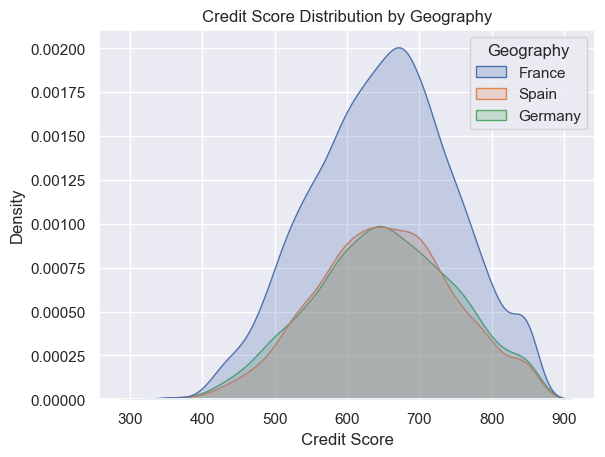

No trends.


In [690]:
# Credit score and geography

sns.kdeplot(data=df, x="CreditScore", hue="Geography", fill=True) 
plt.title('Credit Score Distribution by Geography') 
plt.xlabel('Credit Score') 
plt.ylabel('Density') 
plt.show() 

message ="No trends."
print(message)

### EXITED 

This is our main variable of interest, which we will be studying and trying to predict. It is a binary variable that takes two values: 0 and 1 if that person has exited the bank. For the continuation of our analysis we will use the words 'Stayed' and 'Exited'. 

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/3793788577.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(
/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/3793788577.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Stayed", "Exited"])


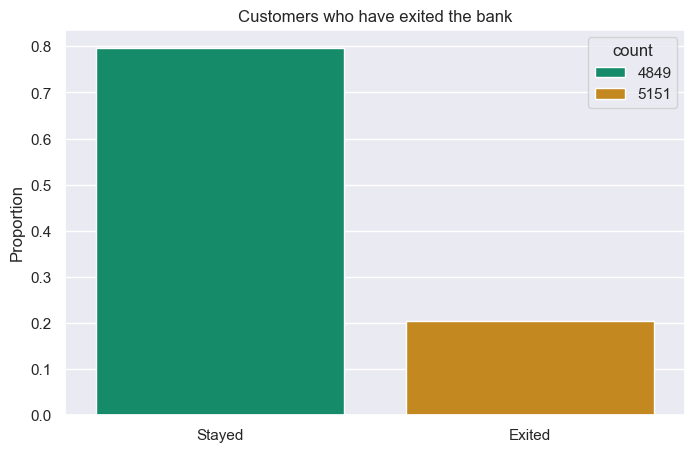

Around 20 percent of customers have exited the bank. This is  a high number which the bank wishes to reduce.


In [691]:
# EXITED 

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(
            x = df["Exited"].value_counts().index,
            y = df["Exited"].value_counts(normalize=True),
            hue=df["IsActiveMember"].value_counts(), 
            palette = sns.color_palette(list(reversed(colors)))
            )

ax.set(
    title = "Customers who have exited the bank",
    xlabel = "",
    ylabel = "Proportion"
)
ax.set_xticklabels(["Stayed", "Exited"])

plt.show()
message="Around 20 percent of customers have exited the bank. This is  a high number which the bank wishes to reduce."
print(message)

# Key factors driving customer churn 

### CUSTOMER PROFILE 

### Age

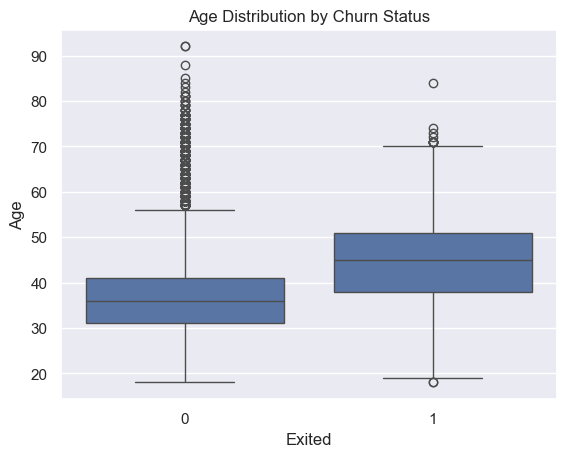

<Figure size 640x480 with 0 Axes>

In [692]:
# How does Age interactw with churn ? 

sns.boxplot(x='Exited', y='Age', data=df) 
plt.title('Age Distribution by Churn Status') 
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Age_distribution.png')

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_4768/2653777596.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_age = df.groupby('Age_group')['Exited'].mean()


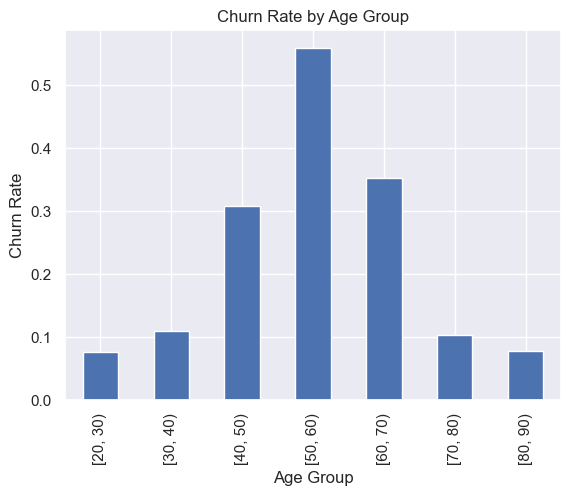

<Figure size 640x480 with 0 Axes>

In [693]:
# Creating age groups (e.g., bin ages into 10-year intervals)

df['Age_group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90], right=False) 
# Calculate churn rate per age group 
churn_rate_by_age = df.groupby('Age_group')['Exited'].mean() 
churn_rate_by_age.plot(kind='bar') 
plt.title('Churn Rate by Age Group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Age Group') 
plt.show()

plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Age_Group_churn.png')

### Geography 

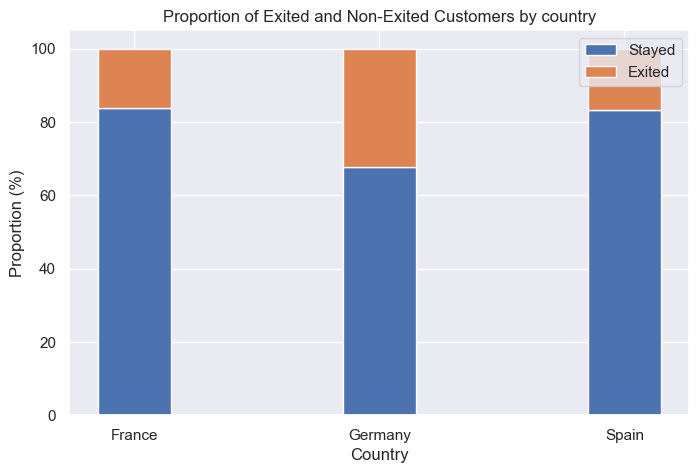

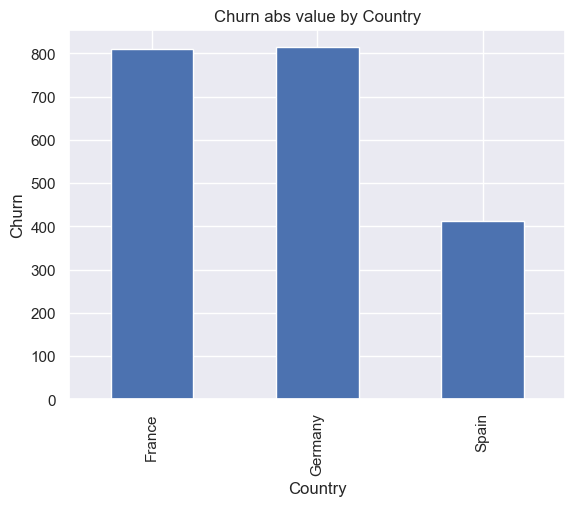

<Figure size 640x480 with 0 Axes>

In [694]:
# How does Geography interacts with churn ? 
    # in relative terms, relative comparison : 
df_geo_exit = (df
      .groupby("Geography")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_geo_exit.index, df_geo_exit[0], label = 'Stayed', width = 0.3) 
ax.bar(df_geo_exit.index, df_geo_exit[1], bottom = df_geo_exit[0], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by country",
    xlabel = "Country",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()

plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Country_churn_perc.png')

    # in absolute count, total number of customers who exited : 
df[df['Exited'] == 1].groupby('Geography')['Exited'].count().plot(kind='bar') 
plt.title('Churn abs value by Country') 
plt.ylabel('Churn') 
plt.xlabel('Country') 
plt.show() # ANNEX

plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Country_churn_absvalue.png')


### Gender

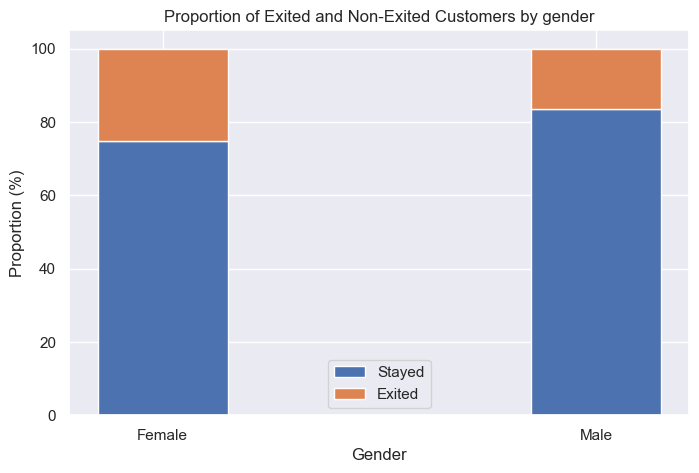

<Figure size 640x480 with 0 Axes>

In [695]:
# What about gender ? 
df_gender_exit = (df
      .groupby("Gender")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_gender_exit.index, df_gender_exit[0], label = 'Stayed', width = 0.3) 
ax.bar(df_gender_exit.index, df_gender_exit[1], bottom = df_gender_exit[0], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by gender",
    xlabel = "Gender",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()

plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Gender_churn.png')
 

In [696]:
# simple summing and percentages
female_df = df[(df['Gender'] == "Female") & (df['Exited'] == 1)].groupby('Geography')['Gender'].count()
male_df = df[(df['Gender'] == "Male") & (df['Exited'] == 1)].groupby('Geography')['Gender'].count()

agg_gender = pd.merge(female_df, male_df, on='Geography', how='inner') 
agg_gender = agg_gender.rename(columns={"Gender_x": "Nbr Female Churning", "Gender_y": "Nbr Male Churning"})

tot_churning = df[df['Exited'] == 1].groupby('Geography')['Gender'].count()
agg_gender["Tot_churning"] = tot_churning

agg_gender["Female Churning (%)"] = (agg_gender['Nbr Female Churning']/ agg_gender['Tot_churning']) * 100
agg_gender["Male Churning (%)"] = (agg_gender['Nbr Male Churning']/ agg_gender['Tot_churning']) * 100
agg_gender = agg_gender.drop(columns=['Tot_churning'])

agg_gender

,Nbr Female Churning,Nbr Male Churning,Female Churning (%),Male Churning (%)
Geography,,,,
France,460,350,56.790123,43.209877
Germany,448,366,55.036855,44.963145
Spain,231,182,55.932203,44.067797


### FINANCIAL ANALYSIS 

### Balance

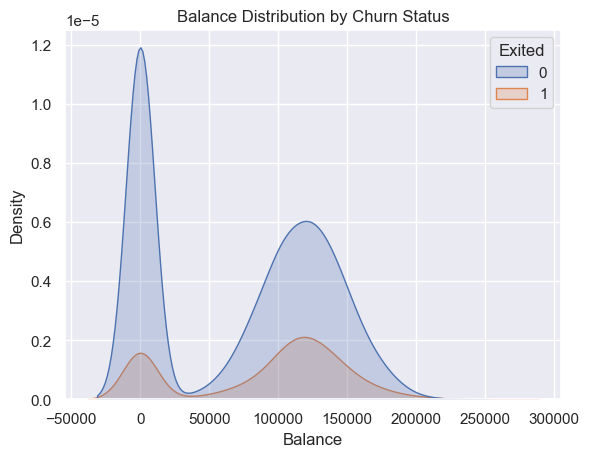

<Figure size 640x480 with 0 Axes>

In [697]:
# How does Balance interact with Churning ? 
sns.kdeplot(data=df, x="Balance", hue="Exited", fill=True) 
plt.title('Balance Distribution by Churn Status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Balance_churn.png')

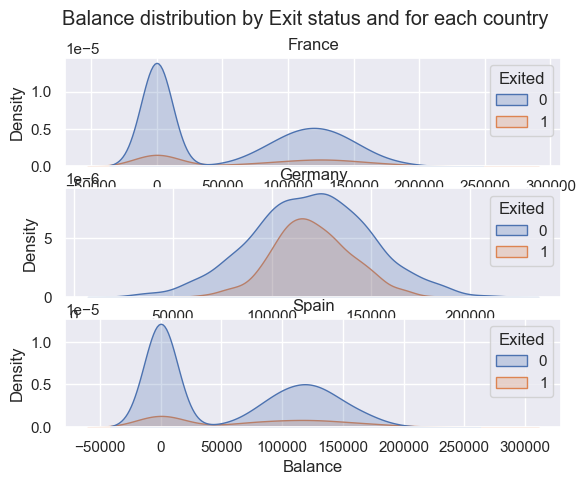

<Figure size 640x480 with 0 Axes>

In [698]:
# Quick look how does Balance interact with churn by country
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df_plot = df[df["Geography"] == country]

    sns.kdeplot(data=df_plot, x="Balance", hue="Exited", fill=True, ax=ax[i]) 

fig.suptitle('Balance distribution by Exit status and for each country')
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Balance_Churn_country.png')

### Estimated Salary 

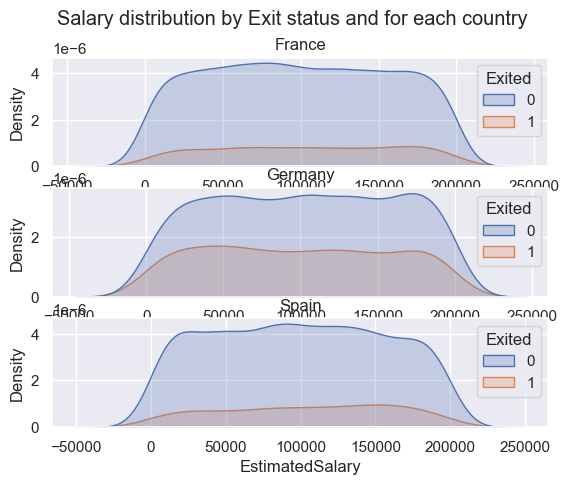

<Figure size 640x480 with 0 Axes>

In [699]:
# How does Salary interacts with churn at the country level? 

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df_plot = df[df["Geography"] == country]

    sns.kdeplot(data=df_plot, x="EstimatedSalary", hue="Exited", fill=True, ax=ax[i]) 

fig.suptitle('Salary distribution by Exit status and for each country')
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Salary_Churn_country.png')

### Credit score

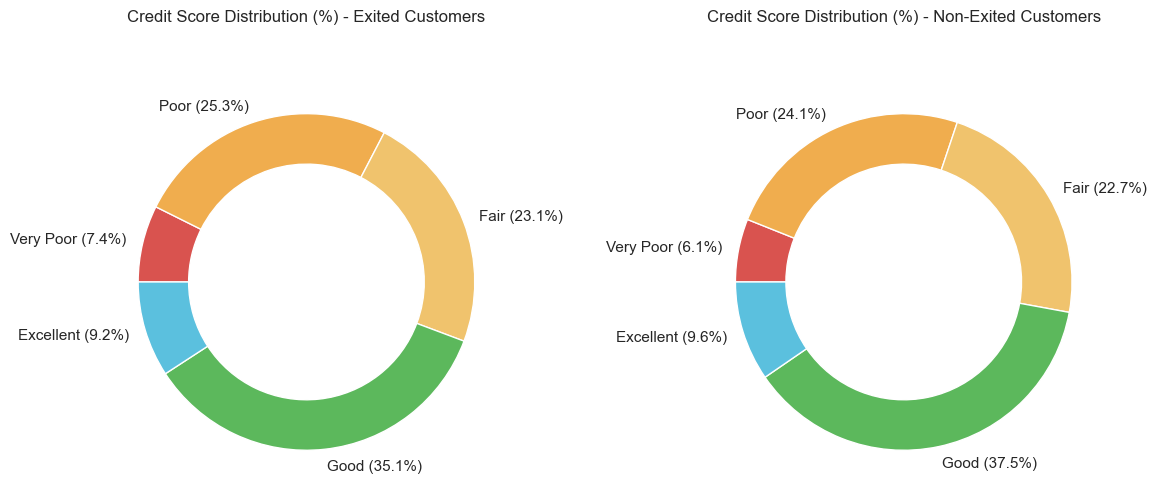

<Figure size 640x480 with 0 Axes>

In [700]:
# We first define the Credit score categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

# Define colors and labels
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']

# Subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# For exited customers
df_credit_exit = df.loc[df["Exited"] == 1].copy()
df_credit_exit['Credit_Category'] = df_credit_exit['CreditScore'].apply(categorize)
category_counts_exit = df_credit_exit['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot exited customers pie chart
axes[0].pie(
    category_counts_exit,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_exit)]
)
axes[0].set_title('Credit Score Distribution (%) - Exited Customers')
axes[0].set_xlim([-1.5, 1.5])
axes[0].set_ylim([-1, 1.5])
axes[0].axis('off')

# For non-exited customers
df_credit_non_ex = df.loc[df["Exited"] == 0].copy()
df_credit_non_ex['Credit_Category'] = df_credit_non_ex['CreditScore'].apply(categorize)
category_counts_non_ex = df_credit_non_ex['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot non-exited customers pie chart
axes[1].pie(
    category_counts_non_ex,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_non_ex)]
)
axes[1].set_title('Credit Score Distribution (%) - Non-Exited Customers')
axes[1].set_xlim([-1.5, 1.5])
axes[1].set_ylim([-1, 1.5])
axes[1].axis('off')

# Show plot
plt.tight_layout()
plt.show()

plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/CreditScore_churn.png')

### ACTIVITY ANALYSIS 

### Years spent in the bank

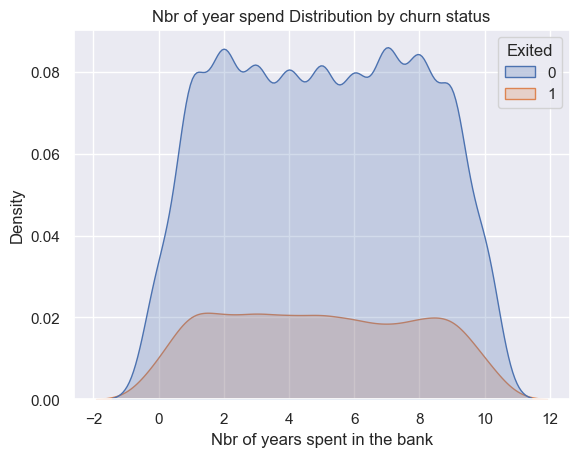

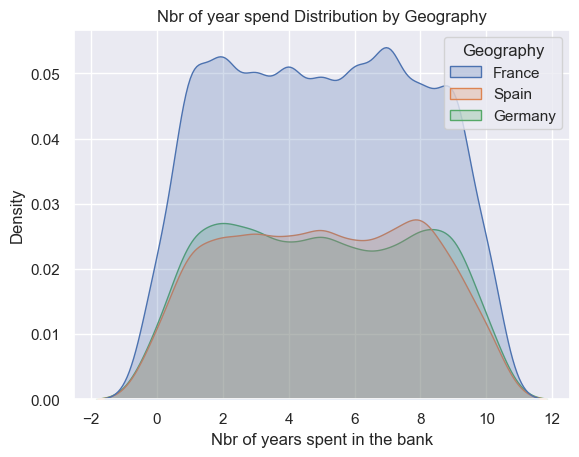

<Figure size 640x480 with 0 Axes>

In [701]:
# Does the one who exit the bank spend more or less years in the bank ?
sns.kdeplot(data=df, x="Tenure", hue="Exited", fill=True) 
plt.title('Nbr of year spend Distribution by churn status') 
plt.xlabel('Nbr of years spent in the bank') 
plt.ylabel('Density') 
plt.show() 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Tenure_Churn.png')

# ANNEX 
    # full view per country 
sns.kdeplot(data=df, x="Tenure", hue="Geography", fill=True) 
plt.title('Nbr of year spend Distribution by Geography') 
plt.xlabel('Nbr of years spent in the bank') 
plt.ylabel('Density') 
plt.show() 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Tenure_per_country.png')


### Products bought

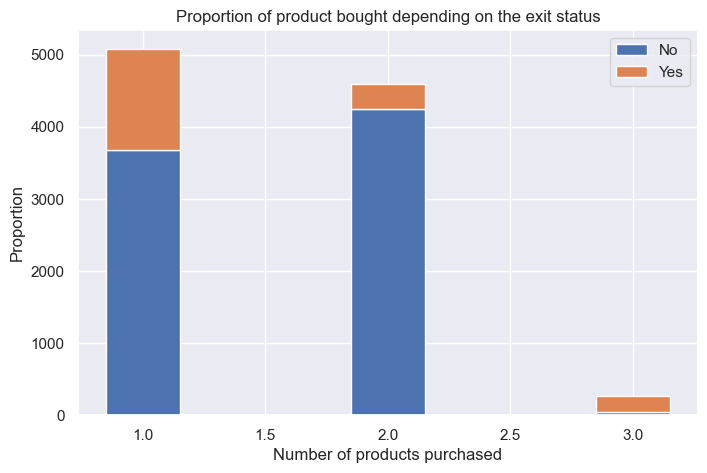

<Figure size 640x480 with 0 Axes>

In [702]:
# Proportion of products bought depending on the exit status
df_prod_geo_churn = (df
      .groupby("NumOfProducts")["Exited"]
      .value_counts()
      #.mul()
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_prod_geo_churn.index, df_prod_geo_churn[0], label = 'No', width = 0.3) 
ax.bar(df_prod_geo_churn.index, df_prod_geo_churn[1], bottom = df_prod_geo_churn[0], label='Yes', width = 0.3)

ax.set(
    title = "Proportion of product bought depending on the exit status",
    xlabel = "Number of products purchased",
    ylabel = "Proportion"
)
ax.legend()
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Prod_Churn.png')

### Activity of customers 

In [703]:
# Simple summing and percentages
country_act_counts = df.groupby('Exited')['IsActiveMember'].value_counts().unstack()
country_act_counts.columns = ['Non-Active Members', 'Recently Active Members']
# country_act_counts

# Calculate the total number of customers per churn status
total = country_act_counts.sum(axis=1)
# total

# Calculate percentages for active and non-active members per churn status
country_act_counts['Recently Active Members (%)'] = (country_act_counts['Recently Active Members'] / total) * 100
country_act_counts['Non-Active Members (%)'] = (country_act_counts['Non-Active Members'] / total) * 100

country_status_percentage = country_act_counts[['Recently Active Members (%)', 'Non-Active Members (%)']]
country_status_percentage

,Recently Active Members (%),Non-Active Members (%)
Exited,,
0,55.456486,44.543514
1,36.082474,63.917526


In [704]:
# Per country split 
# Getting the total members per country for each exit status
country_act_counts_geo = df.groupby(['Geography', 'Exited'])['IsActiveMember'].value_counts().unstack()
country_act_counts_geo.columns = ['Non-Active Members', 'Active Members']
country_act_counts_geo

# Calculate the total number of members per country
country_totals_geo = country_act_counts_geo.sum(axis=1)

# # Calculate percentages for active and non-active members per country
country_act_counts_geo['Active Members (%)'] = (country_act_counts_geo['Active Members'] / country_totals_geo) * 100
country_act_counts_geo['Non-Active Members (%)'] = (country_act_counts_geo['Non-Active Members'] / country_totals_geo) * 100

country_status_percentage_geo = country_act_counts_geo[['Active Members (%)', 'Non-Active Members (%)']]

country_status_percentage_geo

Active Members (%)  Non-Active Members (%)
Geography Exited                                            
France    0                54.543292               45.456708
          1                36.790123               63.209877
Germany   0                56.165192               43.834808
          1                36.363636               63.636364
Spain     0                56.734496               43.265504
          1                34.140436               65.859564

### Credit Card Owner

In [705]:
# TO PLOT